# Final Models

This notebook includes six models for evaluation:

- 1 classifier
- 5 generative models (one per class)

I consolidated all model definitions here to provide a clear and convenient reference for the grading process.

## Setup

In [3]:
# Imports
import import_ipynb

from PIL import Image
from torch import nn
from torchvision.transforms import v2
from utils import DEVICE, classes, sample_image_from_each_class
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils

## Classifier Model

The following cells define my custom CNN-based classifier.
The architecture matches the one evaluated in the classifier notebook, but with two key modifications:

- It now incorporates the input transformations directly within the model.
- Instead of outputting raw logits, the model produces concrete class predictions.

In [4]:
# Model definition
class FinalCNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 32, kernel_size=3, padding='same'),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),

            # Strided convolution instead of MaxPool
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),

            # Strided convolution instead of MaxPool
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2),

            # Flatten and fully connected layers
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),

            # Output layer
            nn.Linear(256, 5)
        )

        # Define the transforms for the input images
        self.transforms = v2.Compose([
            v2.Grayscale(num_output_channels=1),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.1982], std=[0.3426])
        ])

    def forward(self, x):
        # Apply the transformations to the input
        x = self.transforms(x)
        # Pass through the layers
        logits = self.layers(x)
        # Apply argmax to get the predicted class
        return torch.argmax(logits, dim=1)

In [5]:
# Load the correct model weights
classifier = FinalCNN()
classifier.load_state_dict(torch.load('../weights/classifier/final-model.pt'))
classifier.eval()

FinalCNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): LeakyReLU(negative_slope=0.01)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (14): LeakyReLU(negative_slope=0.01)


### Usage example:

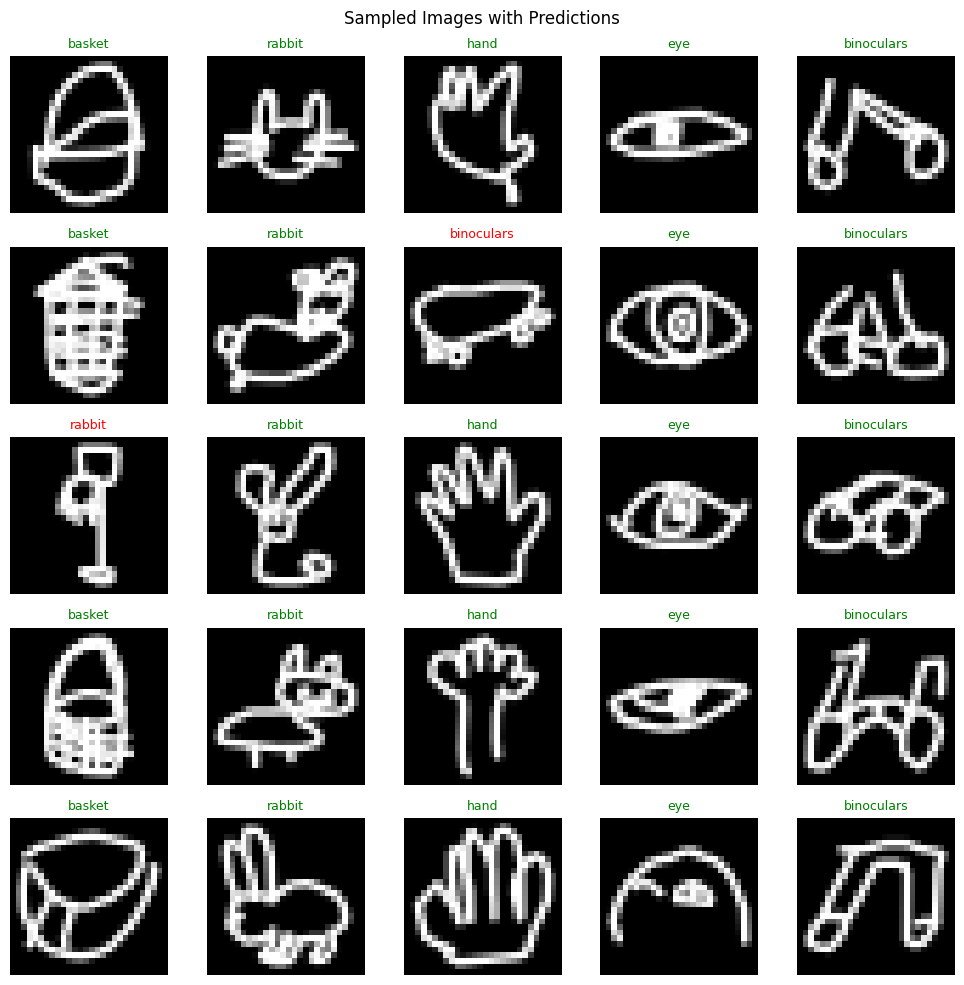

In [6]:
# Sample five images of each class
with torch.no_grad():
    images = sample_image_from_each_class(n=5)

    preds = []
    samples = []

    for true_label, img_path in images:
        image = Image.open(f'../dataset/images/{img_path}').convert('L')

        # unsqueeze image to match dimensions
        to_tensor = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
        ])
        image_tensor = to_tensor(image)

        pred_label = classifier(image_tensor.unsqueeze(0)).item()

        preds.append(pred_label)
        samples.append(image_tensor.cpu())

    num_classes = len(classes)
    n_images_per_class = 5

    fig, axes = plt.subplots(n_images_per_class, num_classes, figsize=(num_classes * 2, n_images_per_class * 2))

    for idx, (true_label, _) in enumerate(images):
        row = idx % n_images_per_class
        col = idx // n_images_per_class

        ax = axes[row, col]
        ax.imshow(samples[idx].squeeze(), cmap='gray')
        ax.axis('off')

        # Predicted class name
        pred_name = classes[preds[idx]]
        color = 'green' if preds[idx] == true_label else 'red'

        # Set predicted label as the title with color
        ax.set_title(pred_name, color=color, fontsize=9)

        ax.set_xlabel(classes[col], fontsize=10)

    plt.suptitle('Sampled Images with Predictions')
    plt.tight_layout()
    plt.show()

## Generative Models

The following cells include the five generators from the generative model notebook.
The only modification made is in the forward function, where generated images are normalized from the range [-1, 1] to [0, 1] for proper visualization and evaluation.

In [7]:
# Model definition
class Generator(nn.Module):
    def __init__(self, z_dim, features_g):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self._block(z_dim, features_g*8, 3, 1, 0), # 3 x 3
            self._block(features_g*8, features_g*4, 5, 2, 1), # 7 x 7
            self._block(features_g*4, features_g*2, 4, 2, 1), # 14 x 14
            nn.ConvTranspose2d(features_g*2, 1, kernel_size=4, stride=2, padding=1), # 28 x 28
            nn.Tanh() # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False # not needed because of batch norm
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, noise):
        return self.gen(noise) * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]

In [8]:
generators = {class_name: Generator(z_dim=100, features_g=64) for class_name in classes.values()}

# Load the generator weights for each class
for class_name in classes.values():
    generator_path = f'../weights/generative/final-model-{class_name}.pt'
    generators[class_name].load_state_dict(torch.load(generator_path))
    generators[class_name].eval()

### Usage Example

Generating images for class: basket


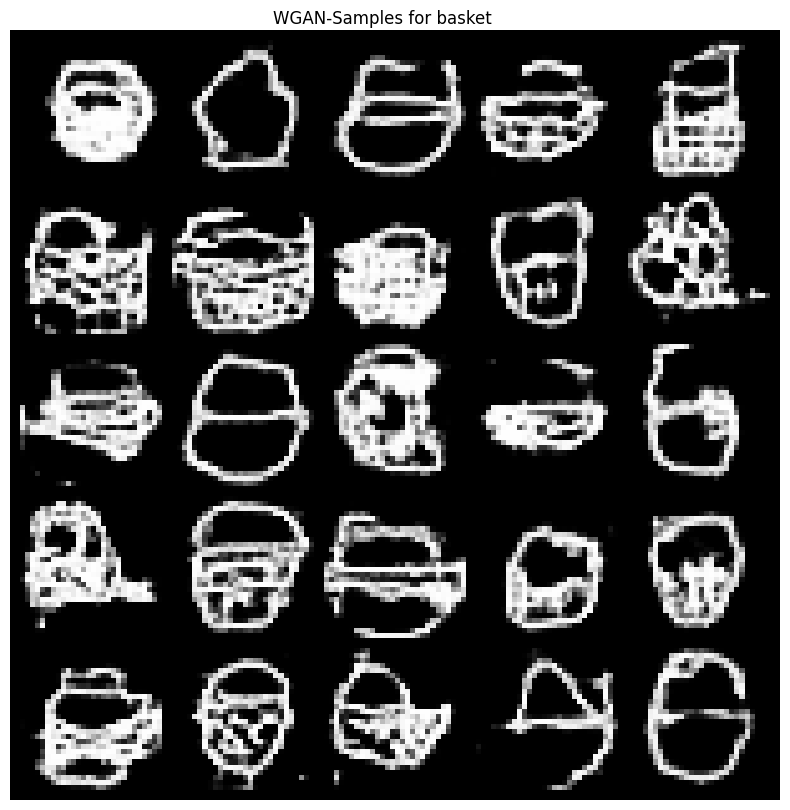

Generating images for class: eye


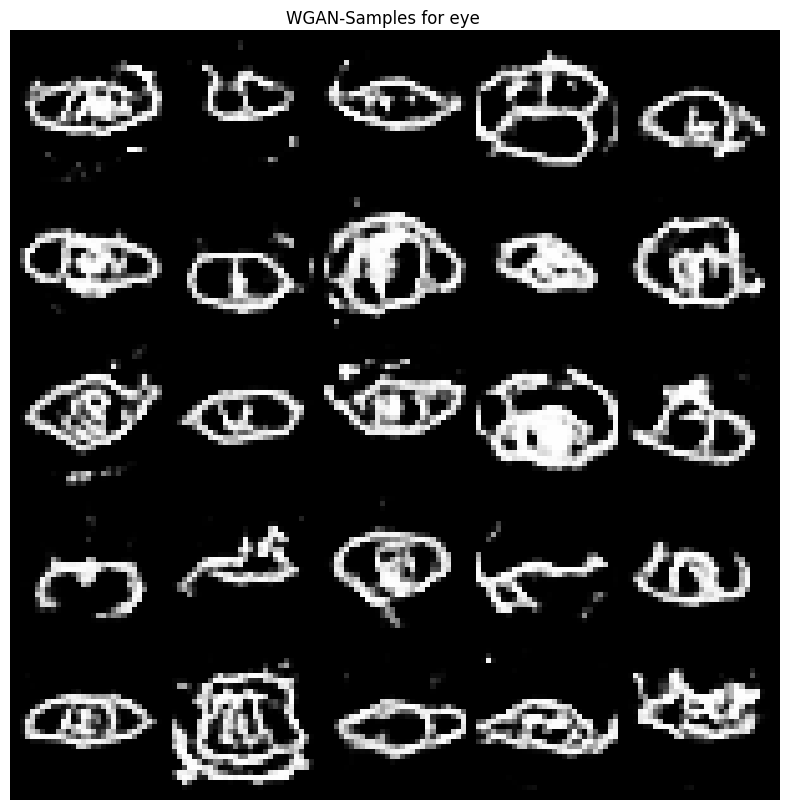

Generating images for class: binoculars


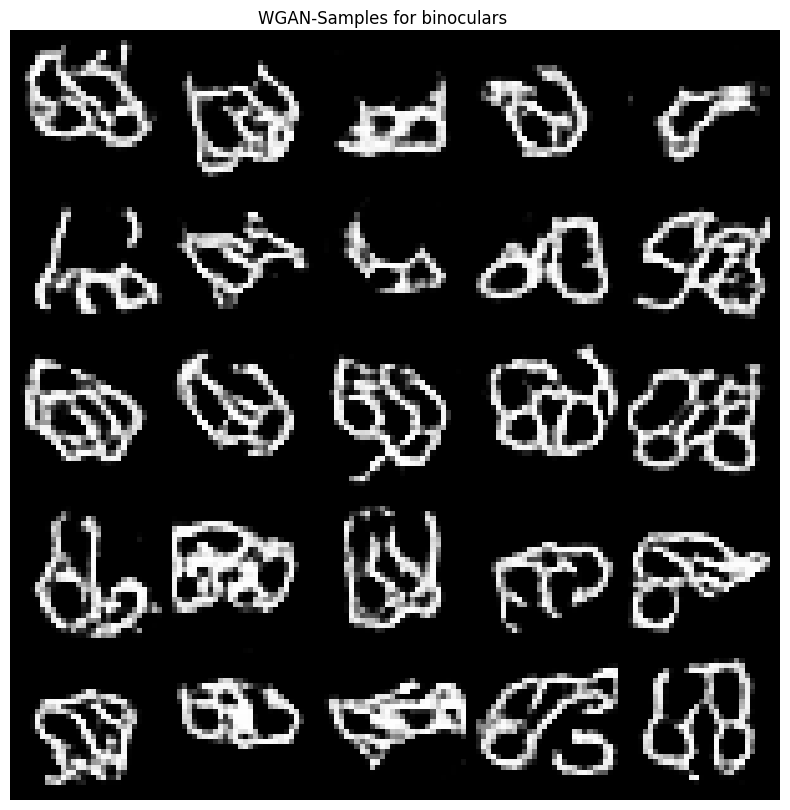

Generating images for class: rabbit


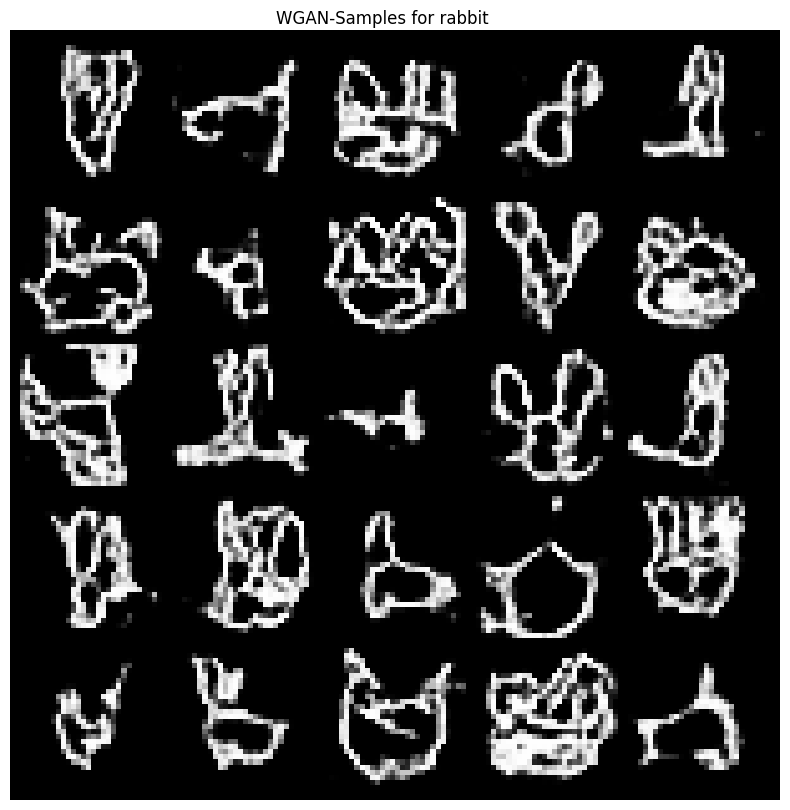

Generating images for class: hand


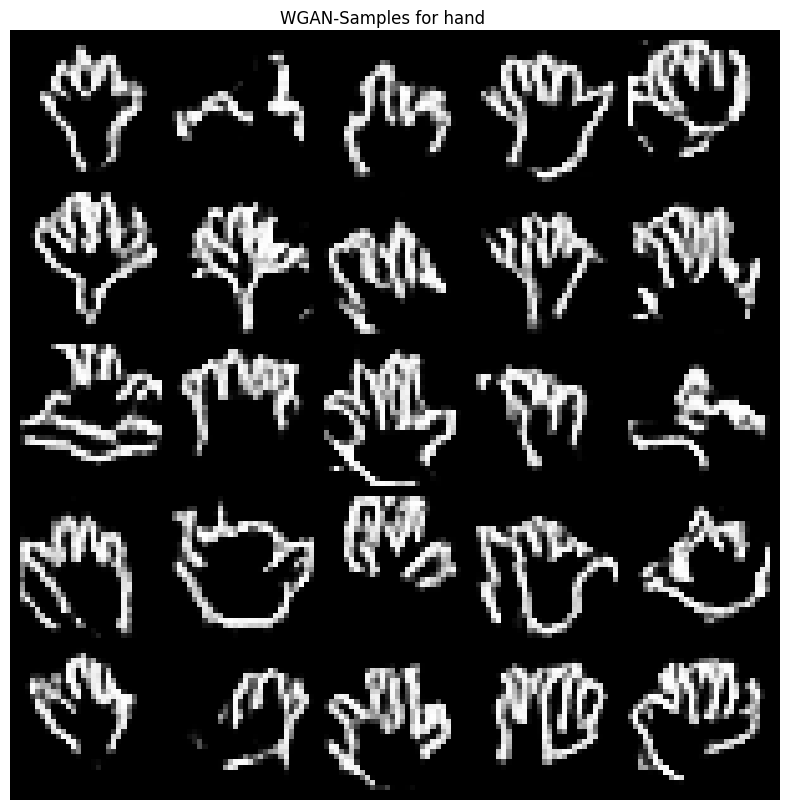

In [9]:
# Show 25 images of each class from the WGAN model
for class_name in classes.values():
    print(f"Generating images for class: {class_name}")

    noise = torch.randn(25, 100, 1, 1).to(DEVICE)

    with torch.no_grad():
        generated_images = generators[class_name](noise)
        generated_images = generated_images.cpu()

    grid_img = vutils.make_grid(generated_images, nrow=5, padding=2, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))  # CHW -> HWC for plt
    plt.axis('off')
    plt.suptitle(f'WGAN-Samples for {class_name}', y=0.9)
    plt.show()